In [2]:
# imports and options
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

In [3]:
# read timelines and match ids and tournament ids
timelines_df = pd.read_csv('../data/match_timelines.csv')
team_names_df = pd.read_csv('../data/match_ids.csv')
tournaments_df = pd.read_csv('../data/tournament_ids.csv')

# select correct tournaments
tournaments_df = tournaments_df[tournaments_df['tournament_id'].isin([57, 58, 59, 60, 61, 62, 102, 103, 104, 105, 106, 107, 152, 153, 154, 155, 156, 157])]

In [4]:
# add column of age group and gender
tournaments_df['age'] = ['F12', 'M12', 'F13', 'F14', 'M13', 'M14',
                         'M13', 'F13', 'F12', 'M12', 'F14', 'M14',
                         'M13', 'F12', 'F13', 'F14', 'M14', 'M12']

# create year column from name
tournaments_df['year'] = tournaments_df['name'].str.extract(r'(\d{4})')

In [5]:
# list international teams
int_teams = ['Nords', 'jylland', 'Shamrock', 'Hamma', 'ndby', 'Vitesse', 'Bromma', 'Liding']

In [6]:
# create boolean variables for international teams
team_names_df['home_team_int'] = team_names_df['home_team'].apply(lambda x: 1 if any(sub in x for sub in int_teams) else 0)
team_names_df['away_team_int'] = team_names_df['away_team'].apply(lambda x: 1 if any(sub in x for sub in int_teams) else 0)

In [7]:
# add home and away team names to main dataframe
timelines_df = timelines_df.merge(team_names_df, on=['tournament_id', 'match_id'], how='left')

# add year and age group to main dataframe
timelines_df = timelines_df.merge(tournaments_df.drop('name', axis=1), on=['tournament_id'], how='left')

# convert times to datetime objects
# Convert to datetime
timelines_df['start_time'] = pd.to_datetime(timelines_df['start_time'], format='mixed')
timelines_df['end_time'] = pd.to_datetime(timelines_df['end_time'], format='mixed')

In [8]:
# Function to calculate Euclidean distance
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

# Apply distance calculation for "Pass" and "Dribble" events
timelines_df['distance'] = np.where(
    timelines_df['event_type'].isin(['Pass', 'Dribble']), 
    euclidean_distance(timelines_df['start_position_x'], timelines_df['start_position_y'], timelines_df['end_position_x'], timelines_df['end_position_y']),
    np.nan  # Assign NaN for other events
)

# calculate duration of event for possible events
timelines_df['duration'] = timelines_df['end_time'] - timelines_df['start_time']
timelines_df['duration'] = timelines_df['duration'].dt.total_seconds() #convert to seconds

# calculate speed for possible events
timelines_df['speed'] = np.where(
    timelines_df['event_type'].isin(['Pass', 'Dribble']), 
    timelines_df['distance'] / timelines_df['duration'],
    timelines_df['speed']
)

# create column of international level (0=f-f, 1=i-f, 2=i-i)
timelines_df['int_level'] = timelines_df['home_team_int'] + timelines_df['away_team_int']

In [9]:
# transform second period into an extension of the first period

# remove matches where there is no first period
valid_matches = timelines_df[timelines_df['period'] == 1]['match_id'].unique()
timelines_df = timelines_df[timelines_df['match_id'].isin(valid_matches)]

# timestamp of last event of first period
first_period_durations = timelines_df[timelines_df['period'] == 1].groupby('match_id')['seconds_from_period_start'].max()

# transform second period timestamps
def transform_time(row):
    if row['period'] == 2:
        return row['seconds_from_period_start'] + first_period_durations[row['match_id']]
    return row['seconds_from_period_start']

timelines_df['seconds_from_period_start'] = timelines_df.apply(transform_time, axis=1)

# drop the 'period' column as it is no longer needed
# timelines_df = timelines_df.drop(columns=['period'])

In [16]:
# pd.options.display.max_rows = 900
# timelines_df[timelines_df['match_id'] == 1346]

### Processing

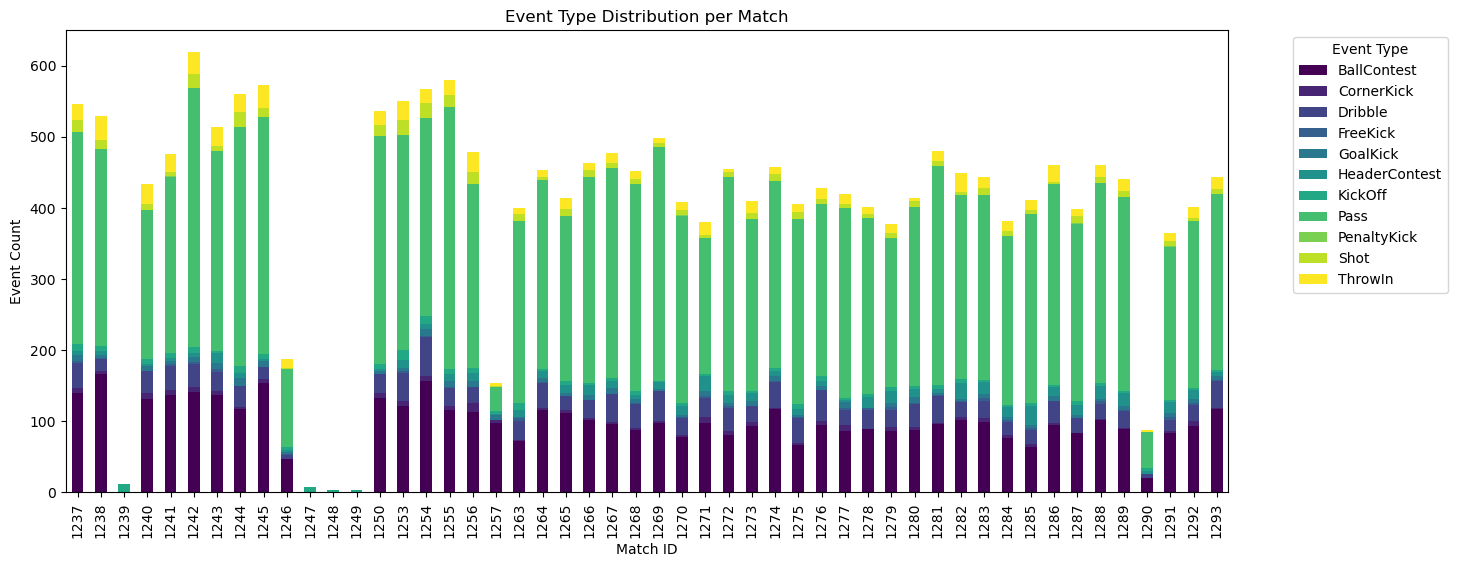

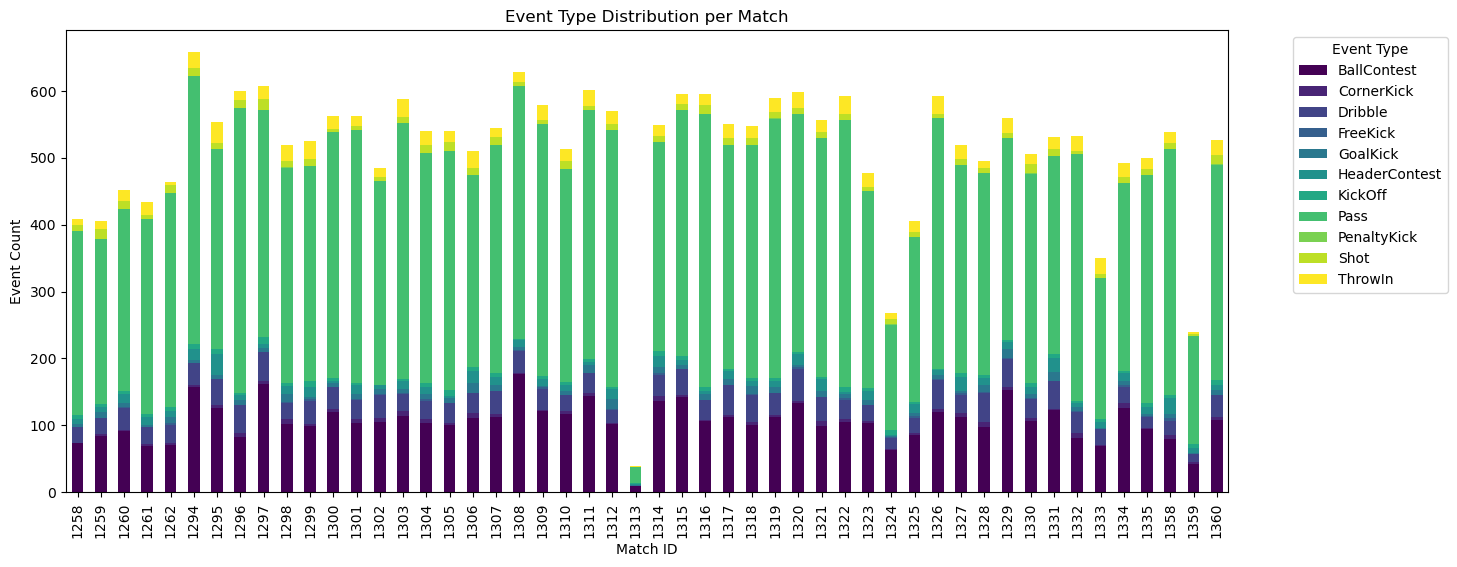

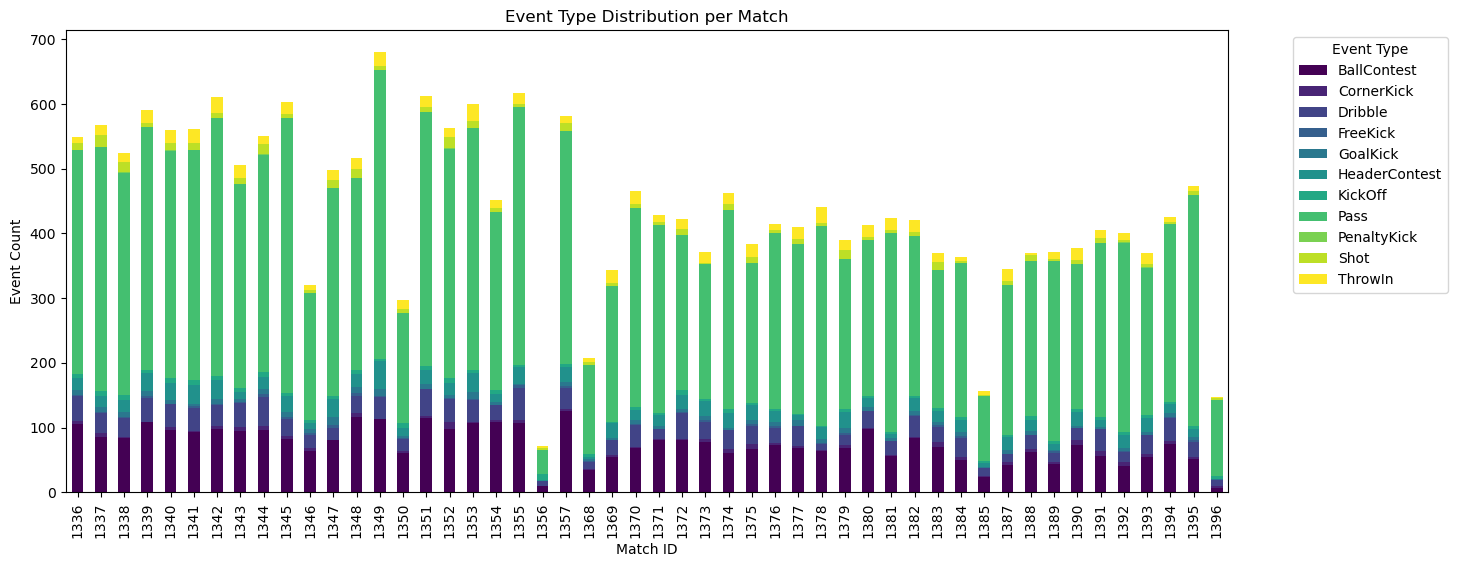

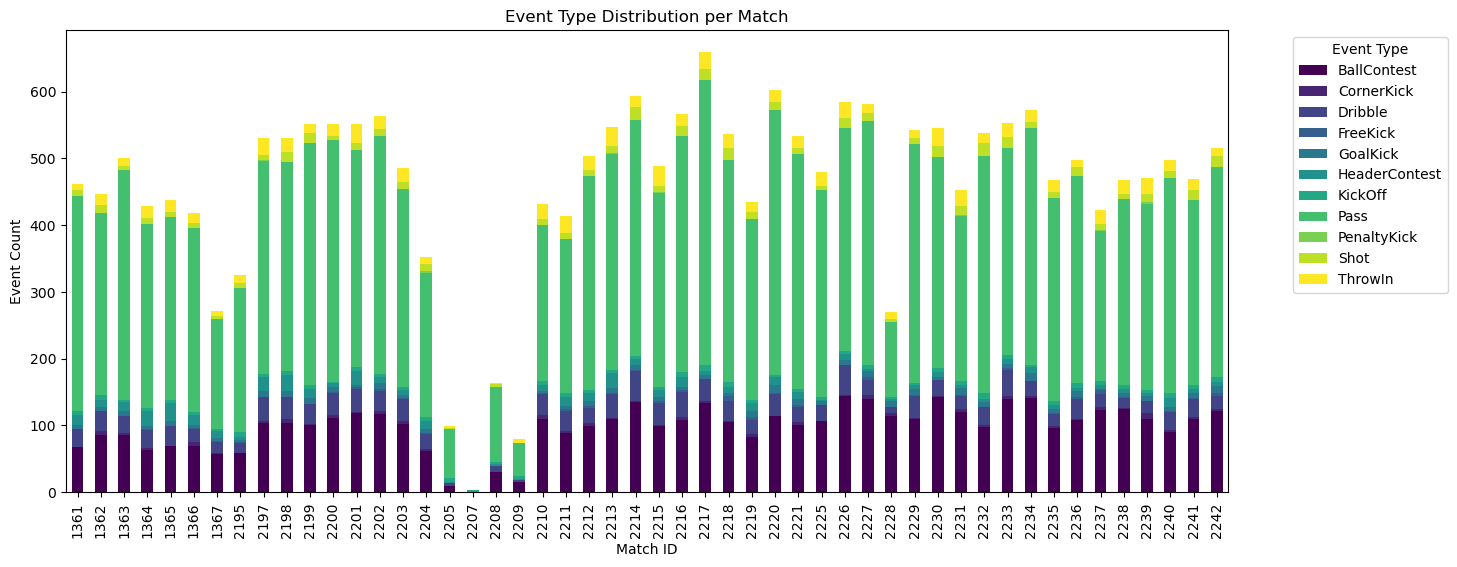

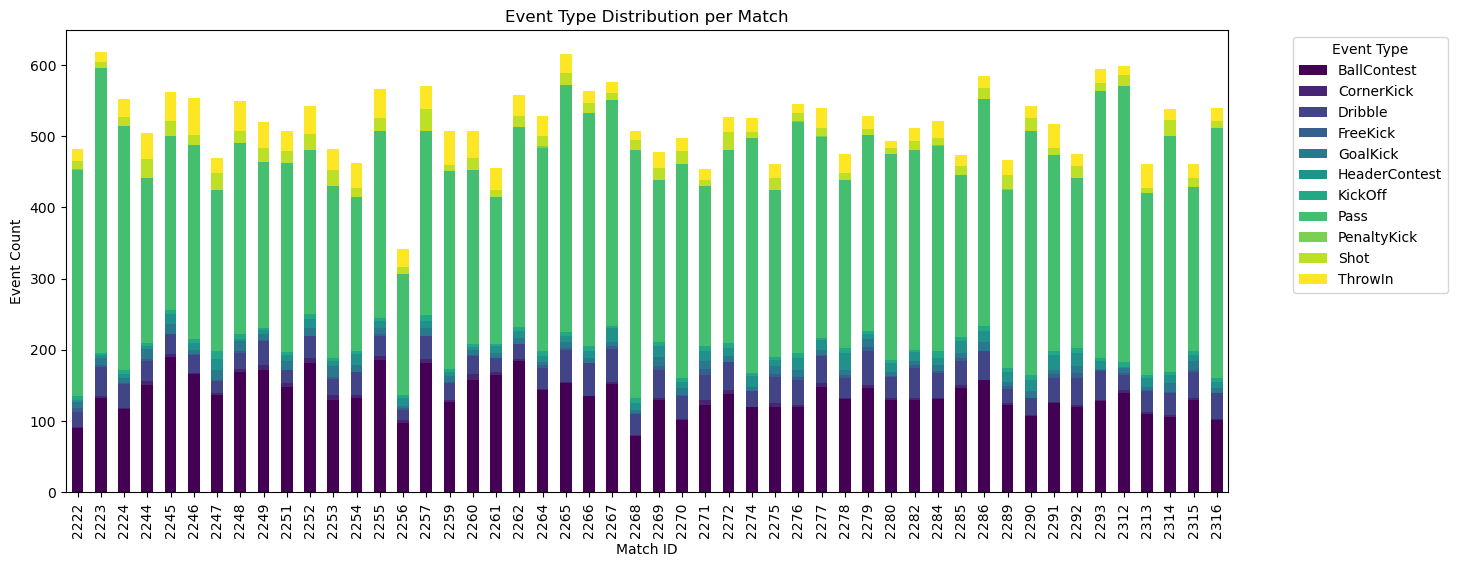

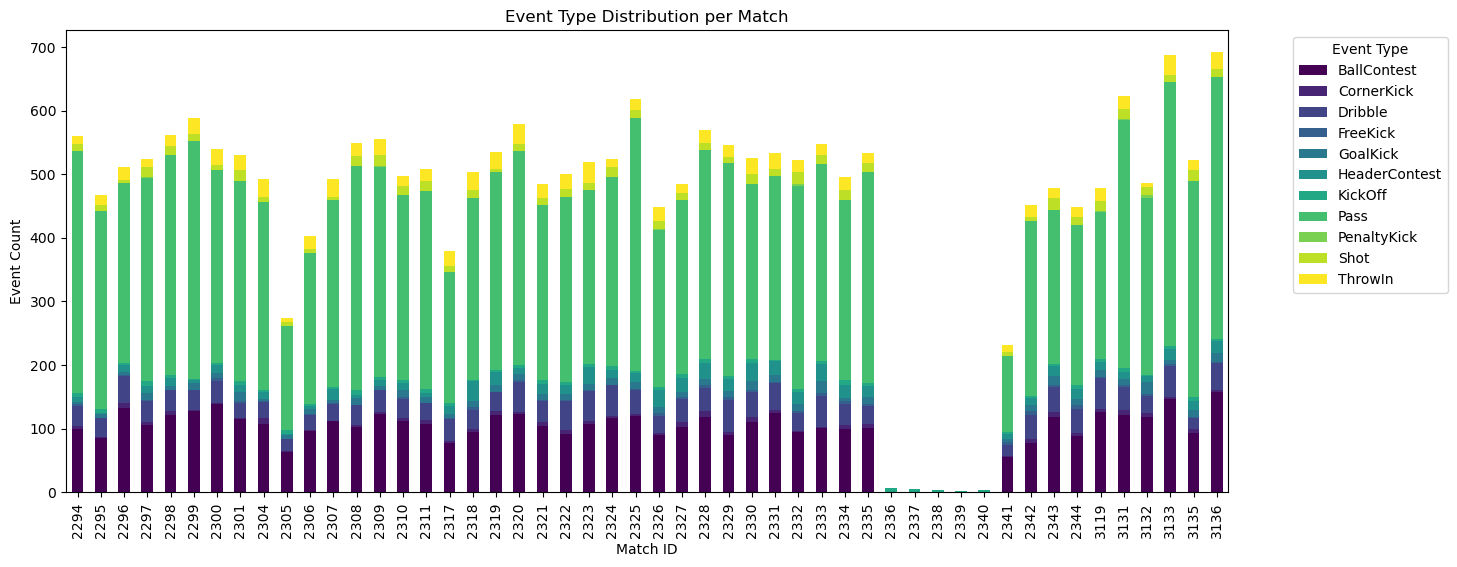

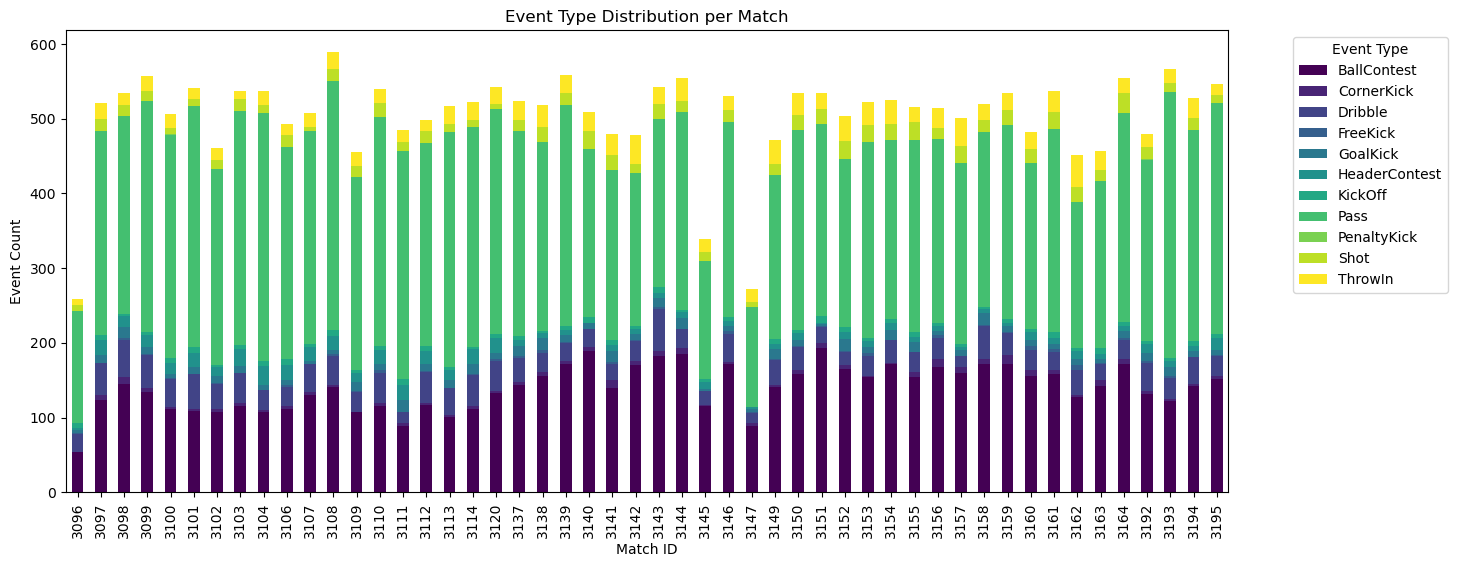

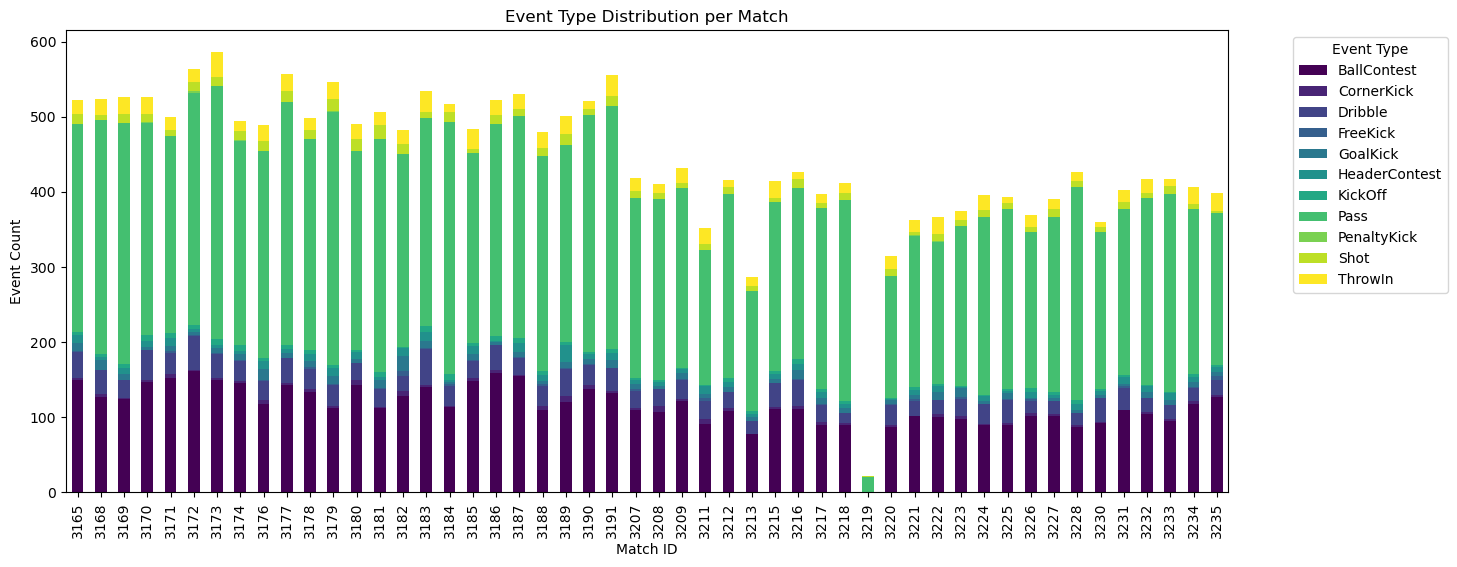

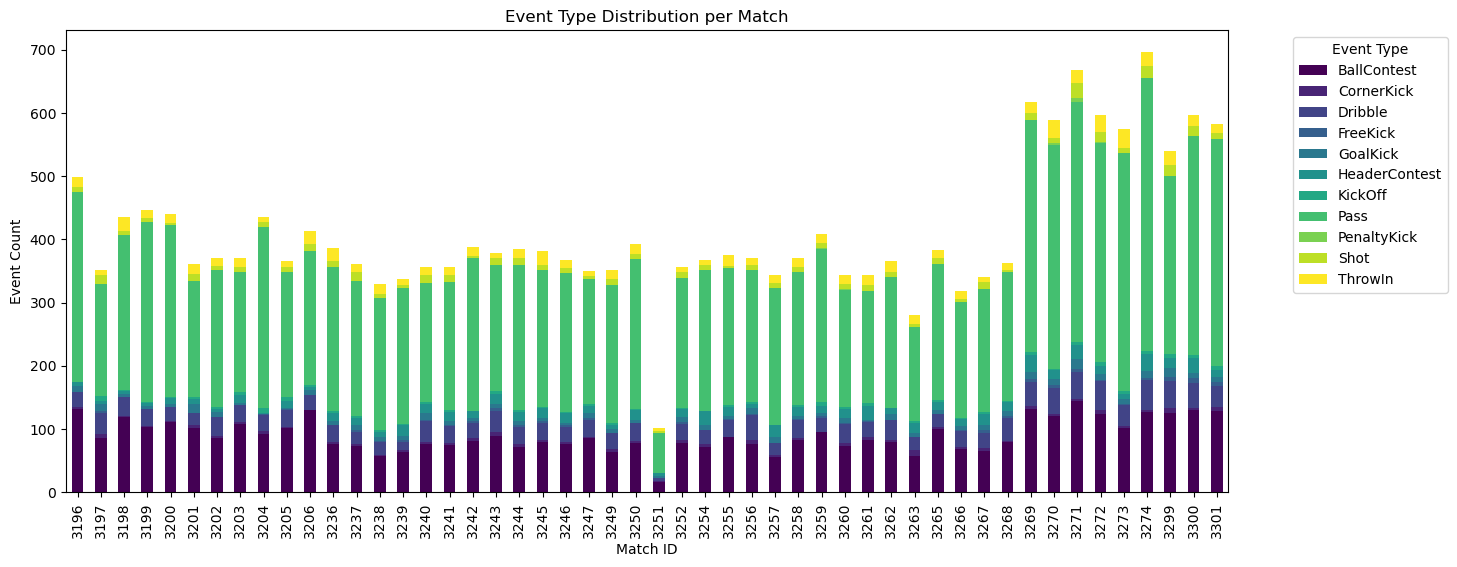

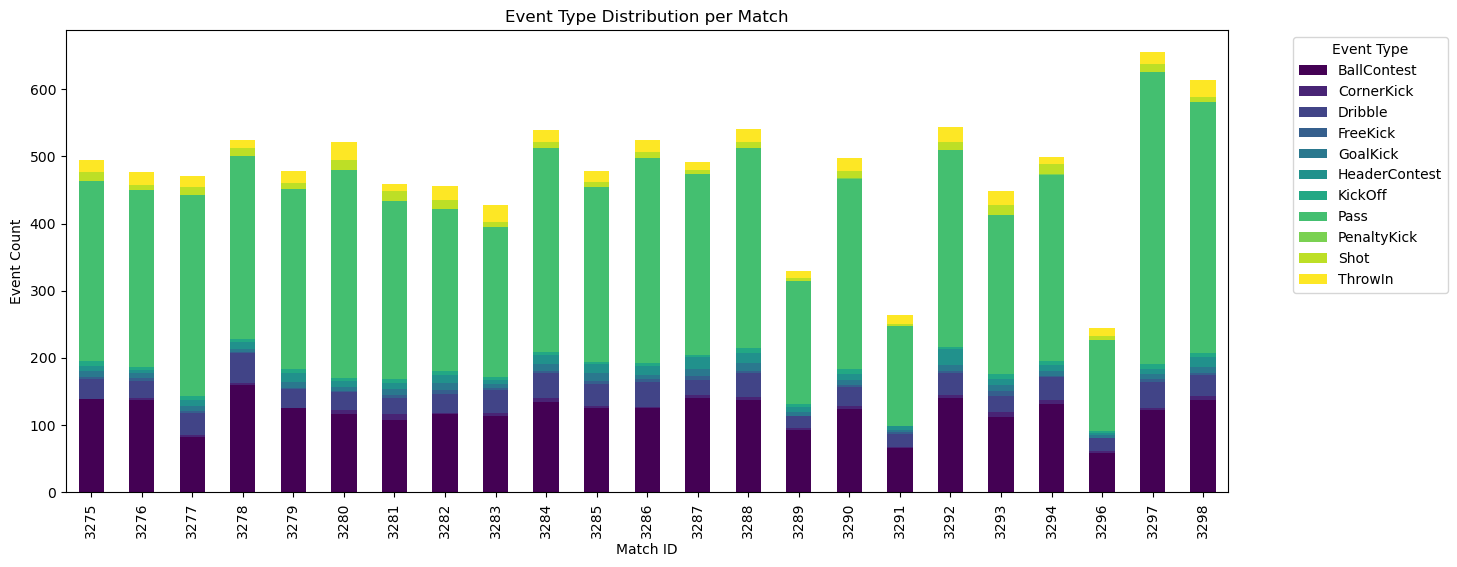

In [ ]:
import matplotlib.pyplot as plt

# match ids and group into groups of 50
match_ids = timelines_df['match_id'].unique()
match_groups = [match_ids[i:i + 50] for i in range(0, len(match_ids), 50)]

# plot 

# count occurrences of each event_type per match a few matches at a time
for matches in match_groups:
    event_counts = timelines_df[timelines_df['match_id'].isin(matches)].pivot_table(index='match_id', columns='event_type', aggfunc='size', fill_value=0)
    event_counts.plot(kind='bar', stacked=True, figsize=(15, 6), colormap='viridis')

    plt.xlabel("Match ID")
    plt.ylabel("Event Count")
    plt.title("Event Type Distribution per Match")
    plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [ ]:
# save dataframe to csv
timelines_df.to_csv('../data/timelines.csv', index=False)